# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection

from scipy.optimize import minimize

## 0.2. Parâmetros do problema

In [2]:
SCALE = 1.0 # How much each screen element is going to be scaled. Default is 1.0
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30 # The width of the screen that contains the overlapping windows in pixels
MAX_WINDOW_DIM = 3 # The max height or width each window can have. For the project the default is 3.
MIN_WINDOW_DIM = 2 # The minimum height or width each window can have. For the project the default is 2.
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 7 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 4 # How far the points can be from the cluster in pixels
KNN_K = 3 # The number of closest neighbors considered for building the connectivity graph

## 0.3. Preprocessamento dos parâmetros

In [3]:
# Rescale
SCREEN_HEIGHT *= SCALE
SCREEN_WIDTH *= SCALE
MAX_WINDOW_DIM *= SCALE
MIN_WINDOW_DIM *= SCALE
CLUSTER_DISTANCE_FROM_SCREEN_CENTER *= SCALE
POINT_DISTANCE_FROM_CLUSTER *= SCALE

SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, de forma que $P_j=(x_j,y_j,h_j,w_j)$. A nivel de implementação, o ponto ainda possui a informação do cluster ao qual ele pertence.

## 1.1 Gerar Centros

In [4]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis

clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [5]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) #

j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER/2,POINT_DISTANCE_FROM_CLUSTER/2, 2)
        # Point dimension
        points[j,2:4] = random.randint(MIN_WINDOW_DIM,MAX_WINDOW_DIM+1,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1
        
points_pos = points[:,:2] # position vectors
points_dims = points[:,2:4] # dimension vectors

## 1.3 Mostrar os dados

<Figure size 432x288 with 0 Axes>

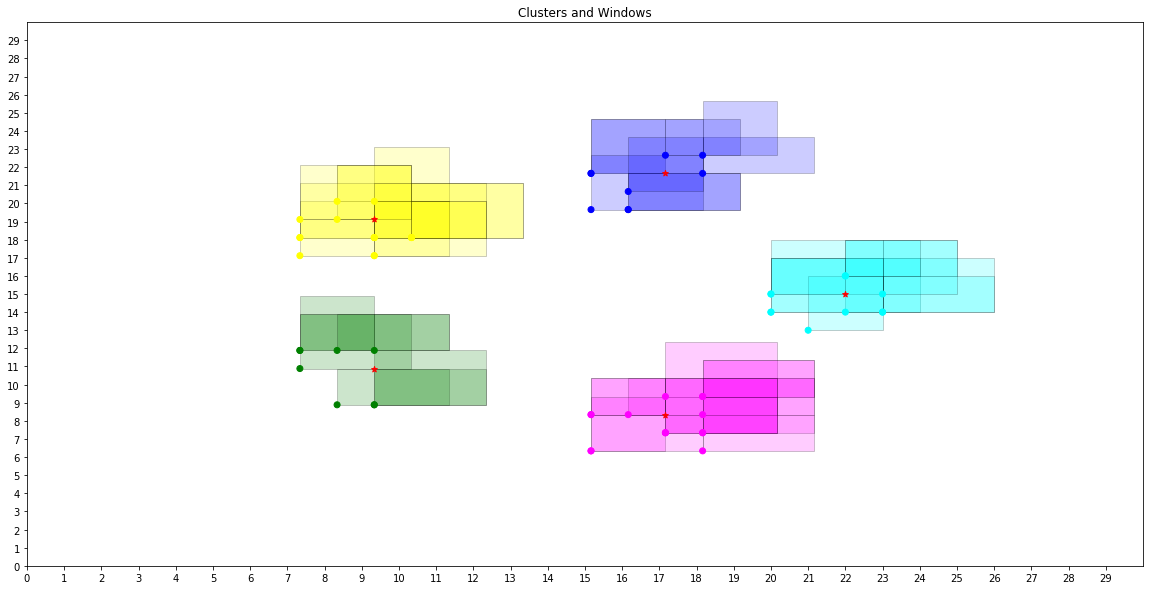

In [6]:
def draw_windows(window_clusters, window_points, window_dims, window_cluster_ids, n_clusters, group_size_list):
    clf()
    fig, ax = subplots(1, figsize=(20,10))
    ax.set_title("Clusters and Windows")
    ax.set_xlim(0, SCREEN_WIDTH)
    ax.set_ylim(0, SCREEN_HEIGHT)
    ax.set_xticks(arange(0, SCREEN_WIDTH, 1 * SCALE))
    ax.set_yticks(arange(0, SCREEN_HEIGHT, 1 * SCALE))
    
    # Draw Rectangles
    rect_clusters_list = [[] for i in range(n_clusters)]
    for j in range(sum(group_size_list)):
        point = window_points[j]
        dim = window_dims[j]
        idx = window_cluster_ids[j]
        rect = Rectangle((point[0], point[1]), dim[0], dim[1])
        rect_clusters_list[int(idx)].append(rect)
    color_list = ["cyan", "blue", "yellow", "green", "magenta", "gray", "black"]
    for i in range(n_clusters):
        rect_list = rect_clusters_list[i]
        pc = PatchCollection(rect_list, facecolor=color_list[i], edgecolor="k", alpha=0.2)
        ax.add_collection(pc)
        
    # Plot points
    colors_idx=window_cluster_ids[:].astype('int32')
    colors = [ color_list[color_idx] for color_idx in colors_idx]
    scatter(window_points[:,0], window_points[:,1], c=colors)

    # Plot Clusters
    ax.scatter(window_clusters[:,0], window_clusters[:,1], c="red", marker="*")
    return

draw_windows(clusters, points_pos, points_dims, points[:,4], n_groups, size_groups)

# 2. Modelagem Matemática


O problema se resume a maximizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [26]:
def plus_operator(val):
    if val > 0:
        return val
    return 0.0

def O_ij(s_i, delta_s_i, s_j, delta_s_j):
    ret_val = 0
    if(s_i >= s_j):
        ret_val =  (1./(delta_s_j ** 4)) * plus_operator(delta_s_j ** 2 - (s_i - s_j) ** 2) ** 2
    else:
        ret_val =  (1./(delta_s_i ** 4)) * plus_operator(delta_s_i ** 2 - (s_i - s_j) ** 2) ** 2
    return ret_val

def check_connected(i, G, V, adjacency_list):
    N = G.shape[0]
    if V[i] == 0: # not visited
        adjacency_list.append(i)
        V[i] = 1
        for idx in range(N):
            if G[i,idx] != 0: # is connected
                check_connected(idx, G, V, adjacency_list) 
    return

def get_unconnected_components(G):
    """
    Returns a list of unconnected components. Each component is a 
    list of the connected vertices within it.
    """
    N = G.shape[0]
    V = zeros((N)) # Visited elements
    unconnected_components = []
    for i in range(N):
        adjacency_list = []
        check_connected(i, G, V, adjacency_list)
        if adjacency_list: # if list is not empty
            unconnected_components.append(adjacency_list)
    return unconnected_components

def adjacency_matrix(X, K=KNN_K):
    N = X.shape[0]
    # Distance matrix first
    D = empty((N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                D[i,j] = linalg.norm(X[i] - X[j])
            else:
                D[i,j] = inf
            
    # From distance matrix, find the K closest elements
    A = zeros((N,N))
    for i in range(N):
        # Gets the k indices that sorts ascending D[i]
        ids = argsort(D[i])
        k_ids = ids[:K]
        for idx in k_ids:
            A[i,idx] = 1.0
            A[idx,i] = 1.0
        A[i,i] = 0.0
    
    # Get unconnected components
    components = get_unconnected_components(A)
    
    # Check the closest edges between each component, being them different among them
    for comp_idx_i in range(len(components)):
        for comp_idx_j in range(len(components)):
            # Ignore connections inside the component
            if comp_idx_i == comp_idx_j:
                continue
            # Create a distance matrix between vertices from the different 
    
    return A


def degree(G):
    """
    Returns the degree of each vertex of an adjacency graph G. The degree matrix is a diagonal
    matrix in which each non-zero element contains the degree of the vertex
    """
    N = G.shape[0]
    D = zeros((N))
    for from_idx in range(N):
        degree = 0.0
        for for_idx in range(N):
            if(G[from_idx, for_idx] != 0):
                degree += 1.0
        D[from_idx] = degree
    return D

def laplacian_graph(X):
    A = adjacency_matrix(X)
    D = degree(A)
    N = A.shape[0]
    L = zeros((N,N))
    for i in range(N):
        for j in range(N):
            if (i != j) and A[i,j] != 0:
                L[i,j] = -1.0 / (1.0 * D[i])
            elif i == j:
                L[i,j] = 1.0
    return L

In [8]:
def E_O(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    sum_e = 0
    n = X.shape[0]
    for i in range(n):
        point_i = X[i]
        # Horizontal
        x_i = point_i[0]
        h_i = points_dims[i,0]
        # Vertical
        y_i = point_i[1]
        v_i = points_dims[i,1]
        for j in range(i+1,X.shape[0]):
            point_j = X[j]
            # Horizontal
            x_j = point_j[0]
            h_j = points_dims[j,0]
            overlapping_h = O_ij(x_i, h_i, x_j, h_j)
            # Vertical
            y_j = point_j[1]
            v_j = points_dims[j,1]
            overlapping_v = O_ij(y_i, v_i, y_j, v_j)
            # Sum
            sum_e += overlapping_h * overlapping_v
    sum_e = 2.0 / (n * (n+1) ) * sum_e
    return sum_e

# For the sake of processing time reduction
_LAPLACIAN_L = laplacian_graph(points_pos)
_DELTA_X = _LAPLACIAN_L.dot(points_pos[:,0])
_DELTA_Y = _LAPLACIAN_L.dot(points_pos[:,1])
def E_N(X):
    N = points.shape[0]
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2)) # Removes w from the state
    delta_x = _DELTA_X
    delta_y = _DELTA_Y
    L = _LAPLACIAN_L
    norm_factor = (N ** 2.0)/( 2.0 * (linalg.norm(delta_x) ** 2 +linalg.norm(delta_y) ** 2) )
    diff_x = linalg.norm( L.dot(X[:,0]) - w * delta_x ) ** 2
    diff_y = linalg.norm(L.dot(X[:,1]) - w * delta_y) ** 2 
    diff_factor = ( diff_x + diff_y)
    sum_e = norm_factor * diff_factor
    return sum_e

# 3. Solução Numérica

In [9]:
alpha = 0.15
def f (x):
    e_n = E_N(x)
    e_o = E_O(x)
    
    print("E_N(X)={} | E_O(X)={}".format(e_n, e_o) )
    return alpha * e_n + (1- alpha) * e_o

## RESTRICOES
#### ATENCAO: AS RESTRICOES DE DESIGUALDADE NO SCIPY SAO O OPOSTO: SAO DO TIPO r(X) >= 0!
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
x_min = 0
x_max = SCREEN_WIDTH
y_min = 0
y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 
#     <=> x_i - x_min >= 0
def constr_fun_1(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = x_min - X[i,0]
        constr[i] = X[i,0] - x_min
    return constr

# r2: x_i - x_max + h_i <= 0 
#     <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        #constr[i] = - x_max + X[i,0] + points_dims[i,0]
        constr[i] = x_max - X[i,0] - points_dims[i,0] - 1
    return constr

# r3: y_min-y_i <= 0 
#     <=> y_i - y_min >= 0
def constr_fun_3(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = X[i,1] -  y_min
        #constr[i] = -X[i,1] + y_min
    return constr

# r4: y_i - y_max + v_i <= 0
#     <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    """
    X is the matrix (N,2) of points.
    """
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    N = X.shape[0]
    constr = zeros((N))
    for i in range(N):
        constr[i] = x_max - X[i,1]  - points_dims[i,1] - 1
        #constr[i] = - x_max + X[i,1]  + points_dims[i,1]
    return constr


cons = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

bounds = []
for idx in range(points_pos.shape[0]):
    point_bound_x = (x_min, x_max - points_dims[idx,0]-1)
    point_bound_y = (y_min, y_max - points_dims[idx,1]-1)
    bounds.append(point_bound_x)
    bounds.append(point_bound_y)
    
w_init = 2.0
X_init = append(points_pos.flatten(), [w_init])
res = minimize(f, X_init , method='SLSQP', constraints=cons, tol=1e-3, options={"maxiter" : 5e1})
X_final = reshape(res["x"][:-1], (points.shape[0], 2))

E_N(X)=1682.0 | E_O(X)=0.05441325207081931
E_N(X)=1682.0 | E_O(X)=0.05441325207081931
E_N(X)=1682.000000763123 | E_O(X)=0.05441325207188322
E_N(X)=1682.0000011056272 | E_O(X)=0.05441325208048274
E_N(X)=1682.0000004037195 | E_O(X)=0.054413252080493364
E_N(X)=1682.000000403719 | E_O(X)=0.05441325207763681
E_N(X)=1681.9999998310013 | E_O(X)=0.05441325208207562
E_N(X)=1681.999999230117 | E_O(X)=0.054413252061601886
E_N(X)=1681.9999993052274 | E_O(X)=0.05441325206746532
E_N(X)=1682.0000010327701 | E_O(X)=0.05441325208400897
E_N(X)=1682.0000003875703 | E_O(X)=0.05441325206854681
E_N(X)=1681.999999002532 | E_O(X)=0.054413252056685214
E_N(X)=1681.9999997866862 | E_O(X)=0.054413252061209644
E_N(X)=1682.000000204301 | E_O(X)=0.05441325208007723
E_N(X)=1681.9999997866855 | E_O(X)=0.054413252064287536
E_N(X)=1682.000000204301 | E_O(X)=0.054413252077351086
E_N(X)=1681.9999998310013 | E_O(X)=0.054413252072835296
E_N(X)=1681.999999230117 | E_O(X)=0.054413252061518924
E_N(X)=1682.0000004037195 | E_O(X

E_N(X)=0.5169870667438994 | E_O(X)=0.05397316911975134
E_N(X)=0.5169870566225065 | E_O(X)=0.053973169132185805
E_N(X)=0.5169870791045933 | E_O(X)=0.05397316911545618
E_N(X)=0.5169870861801045 | E_O(X)=0.05397316911468034
E_N(X)=0.5169870836578019 | E_O(X)=0.05397316909857648
E_N(X)=0.5169870677829512 | E_O(X)=0.053973169097432154
E_N(X)=0.5169870578623306 | E_O(X)=0.0539731691158529
E_N(X)=0.5169870724659245 | E_O(X)=0.05397316909883439
E_N(X)=0.5169870737572986 | E_O(X)=0.05397316912031975
E_N(X)=0.5169870585382684 | E_O(X)=0.05397316911003898
E_N(X)=0.5169870566278812 | E_O(X)=0.05397316912011143
E_N(X)=0.5169870884579544 | E_O(X)=0.053973169109431895
E_N(X)=0.516987065794589 | E_O(X)=0.05397316908459211
E_N(X)=0.5169870719453522 | E_O(X)=0.053973169108773845
E_N(X)=0.5169870668726015 | E_O(X)=0.053973169122943254
E_N(X)=0.5169870433609217 | E_O(X)=0.053973169095981224
E_N(X)=0.5169870977123797 | E_O(X)=0.05397316913567057
E_N(X)=0.5169870760268988 | E_O(X)=0.05397316911305615
E_N(X)

E_N(X)=0.09905354863536624 | E_O(X)=0.05397081958764456
E_N(X)=0.09905354971795696 | E_O(X)=0.05397081959478361
E_N(X)=0.09905355014377791 | E_O(X)=0.05397081960178048
E_N(X)=0.09905353575323027 | E_O(X)=0.053970819599035186
E_N(X)=0.09905353658398126 | E_O(X)=0.05397081960303493
E_N(X)=0.09905354643444612 | E_O(X)=0.05397081957619494
E_N(X)=0.09905355310145533 | E_O(X)=0.05397081959138414
E_N(X)=0.09905354641528616 | E_O(X)=0.05397081957944515
E_N(X)=0.09905355310145338 | E_O(X)=0.05397081959138415
E_N(X)=0.09905354641528558 | E_O(X)=0.05397081957944515
E_N(X)=0.09905354486428661 | E_O(X)=0.05397081958553934
E_N(X)=0.09905354829950372 | E_O(X)=0.05397081960591319
E_N(X)=0.0990535461112558 | E_O(X)=0.053970819599508564
E_N(X)=0.09905354112561118 | E_O(X)=0.053970819590812846
E_N(X)=0.09905355087231252 | E_O(X)=0.053970819604038184
E_N(X)=0.0990535536280479 | E_O(X)=0.05397081959274896
E_N(X)=0.09905354567028701 | E_O(X)=0.05397081959925935
E_N(X)=0.09905354522998372 | E_O(X)=0.05397081

E_N(X)=3.6931189281865793 | E_O(X)=0.054161186895552285
E_N(X)=0.022368968745197258 | E_O(X)=0.05399859566571669
E_N(X)=0.022368968745197258 | E_O(X)=0.05399859566571669
E_N(X)=0.02236897320863554 | E_O(X)=0.053998595666789675
E_N(X)=0.022368968795179002 | E_O(X)=0.053998595675292436
E_N(X)=0.022368969042696175 | E_O(X)=0.0539985956752986
E_N(X)=0.02236897034791697 | E_O(X)=0.053998595672577115
E_N(X)=0.022368969141537354 | E_O(X)=0.05399859567686802
E_N(X)=0.02236896936703671 | E_O(X)=0.053998595656491656
E_N(X)=0.02236896676155092 | E_O(X)=0.0539985956625173
E_N(X)=0.02236896254346972 | E_O(X)=0.05399859567893812
E_N(X)=0.02236896644069839 | E_O(X)=0.05399859566341278
E_N(X)=0.022368971412368807 | E_O(X)=0.05399859565163031
E_N(X)=0.02236896891545481 | E_O(X)=0.053998595656203
E_N(X)=0.022368966417504042 | E_O(X)=0.0539985956748879
E_N(X)=0.02236896890127977 | E_O(X)=0.05399859565915353
E_N(X)=0.02236896642992692 | E_O(X)=0.053998595672296694
E_N(X)=0.022368969184933054 | E_O(X)=0.05

E_N(X)=0.012796542792762652 | E_O(X)=0.05401666802653818
E_N(X)=0.012796540745542243 | E_O(X)=0.05401666803658818
E_N(X)=0.012796540895463364 | E_O(X)=0.054016668021418066
E_N(X)=0.012796541782294724 | E_O(X)=0.05401666802121408
E_N(X)=0.01279654270819924 | E_O(X)=0.0540166680348811
E_N(X)=0.012796542789264774 | E_O(X)=0.054016668022983445
E_N(X)=0.012796539933257448 | E_O(X)=0.05401666800364215
E_N(X)=0.012796541375831725 | E_O(X)=0.0540166680277726
E_N(X)=0.012796541561576068 | E_O(X)=0.05401666803878635
E_N(X)=0.01279653980575674 | E_O(X)=0.054016668051034736
E_N(X)=0.012796538542129454 | E_O(X)=0.054016668033660724
E_N(X)=0.012796542092963228 | E_O(X)=0.05401666803365631
E_N(X)=0.01279654165203405 | E_O(X)=0.05401666801763763
E_N(X)=0.012796541151522532 | E_O(X)=0.05401666801661409
E_N(X)=0.012796538719918576 | E_O(X)=0.05401666803480906
E_N(X)=0.012796539942790463 | E_O(X)=0.05401666801805896
E_N(X)=0.012796539006120664 | E_O(X)=0.05401666803940636
E_N(X)=0.012796539592257702 | E_

# 4. Visualização dos Resultados

<Figure size 432x288 with 0 Axes>

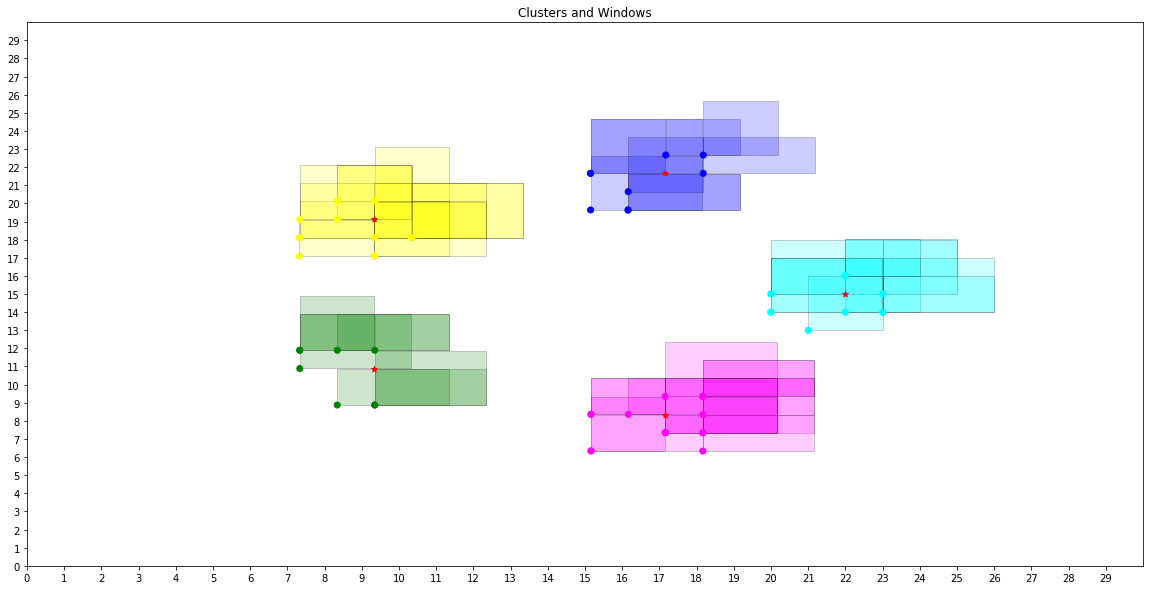

In [10]:
draw_windows(clusters, X_final, points_dims, points[:,4], n_groups, size_groups)

# 5. Elaboração de relatório

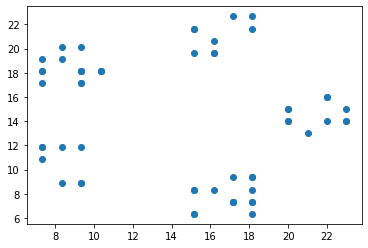

In [13]:
X = points_pos
scatter(X[:,0], X[:,1])

[[0, 3, 1, 2, 7, 8, 4, 9, 5, 6, 10], [11, 15, 18, 12, 13, 16, 14, 17, 19], [20, 27, 32, 21, 26, 25, 34, 33, 31, 22, 28, 23, 24, 30, 29], [35, 36, 38, 42, 41, 37, 39, 40], [43, 50, 45, 49, 44, 46, 47, 48, 56, 53, 54, 57, 51, 52, 55]]


<Figure size 432x288 with 0 Axes>

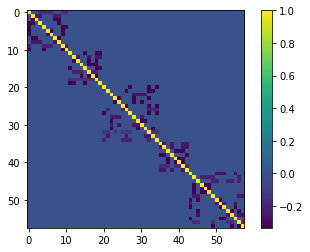

In [27]:
G = laplacian_graph(X)
clf()
fig, ax = subplots()
aa = ax.imshow(G)
cbar = fig.colorbar(aa)
print(get_unconnected_components(G))